## Classification of Parkinson patients using an extra feature of Tapping: Std of the interval.

In [1]:
import synapseclient
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt

In [2]:
def TapPerformance(TapPD1):
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonLeft', 'TappedButtonId'] = 0
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonRight', 'TappedButtonId'] = 1
    TapPD1.loc[TapPD1.TappedButtonId == 'TappedButtonNone', 'TappedButtonId'] = 2
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonLeft'] = 0
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonRight'] = 1
    #TapPD1.TappedButtonId[TapPD1.TappedButtonId == 'TappedButtonNone'] = 2
    TapPD1 = Artifactfixed(TapPD1)
    TapPerf= TapPD1.shape[0]
    Temp=TapPD1.TapTimeStamp.to_numpy()
    Int=Temp[2:-1]-Temp[1:-2]
    TapStd=Int.std()
    return ([TapPerf,TapStd])

In [3]:
#Index=list()
def Artifactfixed(TapCont):
    Ind =  [True] * TapCont.shape[0] #Make a column of Trues
    for item in range(0,TapCont.shape[0]-1):
        if TapCont.TapCoordinate[item]==TapCont.TapCoordinate[item+1]:
            if TapCont.TappedButtonId[item]==2:
                Ind[item]=False
            elif TapCont.TappedButtonId[item+1]==2:
                Ind[item]=False
    TapContArtFixed=TapCont[Ind]
    
    return TapContArtFixed
          

In [4]:

syn = synapseclient.Synapse()
syn.login('catarivera8', 'Crm1061709701')


## QUERY THE mPower PROJECT (syn4993293) FOR ALL OF THE TABLES
# See examples: https://python-docs.synapse.org/build/html/index.html 
# and https://www.synapse.org/#!Synapse:syn4993293/discussion/threadId=6785
with open('TappingTable.csv') as csvfile:
    TapTable=pd.read_csv(csvfile, delimiter=',')
with open('DemoTable.csv') as csvfile:
    DemoTable=pd.read_csv(csvfile, delimiter=',') 

#Using Patient column (healthCode) as index for the Data frames
#TapTableB = TapTable.set_index("healthCode", drop = False) 
#DemoTableB = DemoTable.set_index("healthCode", drop = False)    

      
#TapPD = list()
PathList = list()
LabelList = list()
#PatientType = list()
#PatientList = list()
#AgeList = list()
Perform =list()
TapStd = list ()
for offset in range(0,100,100):
    results = syn.tableQuery('SELECT * FROM syn5511439 LIMIT 100 OFFSET '+str(offset))
    file_map=syn.downloadTableColumns(results,['tapping_results.json.TappingSamples'])
    for file_handle_id, path in file_map.items():
        #TapPD.append(pd.read_json(path))
        PathList.append(path)
        LabelList.append(int(file_handle_id))
        #PatientType.append(TapTableB['medTimepoint'][TapTable['tapping_results.json.TappingSamples'] == int(file_handle_id)])
        Perform.append(TapPerformance(pd.read_json(path))[0]) #Tap performance
        TapStd.append(TapPerformance(pd.read_json(path))[1]) #Tap performance
        #PatientList.append(TapTableB['healthCode'][TapTableB['tapping_results.json.TappingSamples'] == int(file_handle_id)])
        #DemoTableB.loc[(TapTableB['healthCode'][TapTableB['tapping_results.json.TappingSamples'] == int(file_handle_id)]),"age"]
        

Welcome, Catalina Rivera!



In [5]:

TapPerformance(pd.read_json(path))[1]

0.056573108573882286

## Building data frame using tapping performance and demographic information

In [23]:
TapTable.columns
#Drop columns no needed
TapTable=TapTable.drop(['ROW_ID', 'ROW_VERSION','recordId','createdOn','appVersion','phoneInfo','accel_tapping.json.items','tapping_results.json.ButtonRectLeft','tapping_results.json.ButtonRectRight','tapping_results.json.endDate','tapping_results.json.startDate','tapping_results.json.TappingViewSize','medTimepoint'], axis=1)
#Creating directory
d = {'tapping_results.json.TappingSamples':LabelList,'TapPerform':Perform,'TapStd':TapStd}
PerfInfo = pd.DataFrame(d)
#Merges TapTables with the PerfInfo and drops thos values in TapTable that are not defined in PerInfo
#TapTable=TapTable.merge(PerfInfo,left_on='tapping_results.json.TappingSamples', right_on='tapping_results.json.TappingSamples')
TapTable=TapTable.merge(PerfInfo)


KeyError: "['ROW_ID' 'ROW_VERSION' 'recordId' 'createdOn' 'appVersion' 'phoneInfo'\n 'accel_tapping.json.items' 'tapping_results.json.ButtonRectLeft'\n 'tapping_results.json.ButtonRectRight' 'tapping_results.json.endDate'\n 'tapping_results.json.startDate' 'tapping_results.json.TappingViewSize'\n 'medTimepoint'] not found in axis"

In [7]:

#Sub-DataFrame of Demo Table with only features of interest: Age, diagnostic year, gender.
#DemoTable.head()
DemoTableN=DemoTable[["age","healthCode","diagnosis-year","gender"]]
DemoTableN.shape
#Merges TapTables with the PerfInfo and drops thos values in TapTable that are not defined in PerInfo
TapTableN=TapTable.merge(DemoTableN)
TapTableN.head()
TapTableN.shape



(8759, 7)

In [8]:
TapTableN=TapTableN.dropna(subset=['age','gender'])

In [9]:
# change gender column to categorical 0:female, 1: male
df_gender = pd.get_dummies(TapTableN['gender'],drop_first=True)
#print(TapTableN.gender.value_counts())
TapTableN = pd.concat([TapTableN, df_gender], axis=1)
TapTableN=TapTableN.drop(['healthCode', 'tapping_results.json.TappingSamples','gender'], axis=1)



In [10]:
TapTableN.head()


,TapPerform,TapStd,age,diagnosis-year,Male,Prefer not to answer
0,294,0.055531,24.0,NaN,1,0
1,289,0.067300,38.0,NaN,0,0
2,374,0.051683,38.0,NaN,0,0
3,164,0.086007,32.0,NaN,1,0
4,229,0.072284,32.0,NaN,1,0


In [11]:
# diagnosis-year becomes years with diagnosed disease
TapTableN['diagnosis-year']=(2015-TapTableN['diagnosis-year'])
#NAN REPLACED WITH ZERO AND OTHER INT REPLACED WITH ONE
dfb = TapTableN['diagnosis-year'].notnull().astype(int)
TapTableN['YearsPD']=dfb
print(TapTableN)


      TapPerform    TapStd   age  diagnosis-year  Male  Prefer not to answer  \
0            294  0.055531  24.0             NaN     1                     0   
1            289  0.067300  38.0             NaN     0                     0   
2            374  0.051683  38.0             NaN     0                     0   
3            164  0.086007  32.0             NaN     1                     0   
4            229  0.072284  32.0             NaN     1                     0   
...          ...       ...   ...             ...   ...                   ...   
8754          99  0.188803  70.0             4.0     1                     0   
8755          62  0.205342  70.0             4.0     1                     0   
8756         176  0.119105  61.0             1.0     1                     0   
8757         477  0.039186  38.0             NaN     1                     0   
8758         241  0.029536  25.0             NaN     1                     0   

      YearsPD  
0           0  
1      

In [12]:
X=TapTableN[['TapPerform', 'age','Male']]
y=TapTableN['YearsPD']

## Building the model

In [13]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [24]:
classifiers = [LogisticRegression(random_state=13), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=13),
               RandomForestClassifier(random_state=13)]


# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

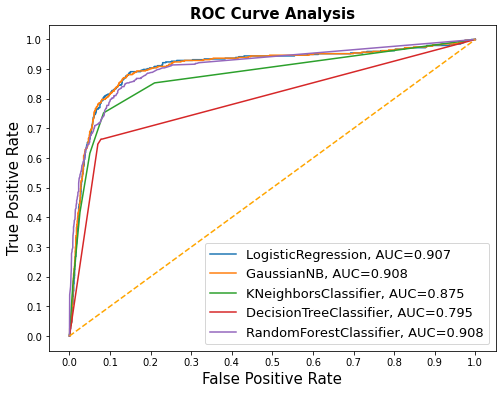

In [25]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [17]:
#Notes on the Report:
#Precision 0: TN/(TN+FN) of those predicted with out the disease, which how many really do not have it.
#Precision 1: TP/(TP+FP) of those predicted with the disease, which how many really had it.
#Recall 0: TN/(TN+FP) of those that dont have the disease how many were predicted with out the disease
#Recall 1: TP/(TP+FN) of those that have the disease how many were predicted with the disease
#Accuracy: TP+TN/(TP+TN+FP+FN), how many were classified correctly.
#For early diagnosis we would like to focus on recall 1 to be high. People with early stages of the disease should diagnose
#Few false negatives.

## Using only people before taking medication


In [18]:
#TapTableB = TapTableN[TapTableN['medTimepoint'] != "Just after Parkinson medication (at your best)"] 
#TapTableC = TapTableB[TapTableB['medTimepoint'] != "Another time"] 

#XX = TapTableC[['TapPerform','age','Male','Prefer not to answer']].to_numpy()
#YY=TapTableC['PDOn'].to_numpy()
#YY[YY!=0] = 1

#XX_train, XX_test, yy_train, yy_test = train_test_split(XX,YY , test_size=0.3, random_state=1)

##Training logistic regression
#logregC = LogisticRegression()
#logregC.fit(XX_train, yy_train)
#yy_predC = logregC.predict(XX_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregC.score(XX_test, yy_test)))
#confusionMatrixC = confusion_matrix(yy_test, yy_predC)
#print(confusionMatrixC)
#print(classification_report(yy_test, yy_predC))
#dispC = plot_confusion_matrix(logregC, XX_test, yy_test,cmap=plt.cm.Blues)



In [19]:
##Plotting ROC Curve

##Calculate probabilities. Notice that this is different than evaluating the predict y_pred
#y_probC = logregC.predict_proba(XX_test)
#y_prob1C = y_probC[:, 1]

#fprC, tprC, thresholdC = metrics.roc_curve(yy_test, y_prob1C)
#roc_aucC = metrics.auc(fprC, tprC)

#plt.title('Receiver Operating Characteristic')
#plt.plot(fprC, tprC, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()
##Saving this for using the new threshold
##y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3
##print(fprC)
##print(fpr)

## Graph to see time dependency

In [20]:
#Prob = logreg.predict_proba(X)
#ProbOfPD=Prob[:, 1]
#Ind=(TapTableN["diagnosis-year"]!=0)
#YearsPD=TapTableN["diagnosis-year"]
#nd=(YearsPD!=0)
#YearsPD[Ind]=(2015-YearsPD[Ind])
#plt.scatter(YearsPD, ProbOfPD, c="g", alpha=0.5, marker=r'$\clubsuit$',
#            label="Luck")
#plt.xlim([-0.5, 20])
#print(ProbOfPD[42])
#print(YearsPD[42])
##TapTableN["TimeDis"][Ind]=(2015-TapTableN["diagnosis-year"][Ind])
##print(TapTableN["age"][72])

## Classifying using diagnostic year as starting point of the disease

In [21]:
#Let us look at a histogram of the diagnosis year and find quantiles


#Bol=TapTableN["diagnosis-year"]!=0 
#Diagnosis=TapTableN["diagnosis-year"][Bol]
#Bol2=Diagnosis>1960
#Diagnosis= 2015-Diagnosis[Bol2]
#print(Diagnosis)
##hist = Diagnosis.hist(bins=10)
#YearsDiaQuant=Diagnosis.quantile([.25, .5, 0.75])

##Drop values were diagnosis year does not make sense
#Diagnosis = Diagnosis[Diagnosis > 15]
#print(Diagnosis)




## Classifier for first quantile